# Determining optimal thresholds for the absolute difference ratios
The IFT relies on similarity metrics to filter candidate floes and to find a best match. The current implementation uses a distance criterion (investigated in a separate notebook) and a two-stage shape similarity assessment. In each case the matching is based first on performance against thresholds. The thresholds are divided into "small" and "large" floe categories. In this notebook, we examine the results of a numerical experiment and a set of matched, manually validated floe pairs. We aim to understand:

* How sensitive is each measure to the uncertainty in the floe shape?
* How confident can we be in rejecting a match based on the results of the measures?
* How much power does each measure have at rejecting false matches?
* How much does the measure depend on the area of the floe?
* Is there a natural separation between "small" and "large" floes?

# Data and experiments
## 1. Effect of rotation on geometric comparisons
Prior to running the notebook, run the Julia script `rotation_test_floe_shapes.jl`. This method takes each floe shape larger than 50 pixels, then uses binary image rotation with nearest neighbor interpolation to rotate the shapes a range of angles from -45 to +45 degrees. Nearest-neighbor interpolation is the lowest-accuracy interpolation method, so these can give us an upper bound on the uncertainty just due to rotation of digital representations of shapes. So that floes are only used once in the analysis, we only use the *Aqua* images for this portion. 

After each rotation, we compute the absolute difference ratios:
$$ ADR(X, Y) = \frac{2|X - Y|}{X + Y} $$

from which we compute pair of floe shapes $f$ and $g$:

* $ADR_{area} = ADR(\mbox{area}(f), \mbox{area}(g))$
* $ADR_{convex} = ADR(\mbox{convex\_area}(f), \mbox{convex\_area}(g))$
* $ADR_{axmin} = ADR(\mbox{axis\_minor\_length}(f), \mbox{axis\_minor\_length}(g))$
* $ADR_{axmin} = ADR(\mbox{axis\_major\_length}(f), \mbox{axis\_major\_length}(g))$

We divide the data by case into a training and testing dataset, then determine the upper bounds for each threshold for error due to rotation. For a measure $m$, floe $f$, and rotation amount $\theta$ we compute
$$\max_{\theta}(m(f, R_\theta \circ f)$$
where $R_\theta$ is the rotation matrix.

## 2. Variation of metrics for matched floe shapes
For this section, we use the paired floe data linking floes found in the *Aqua* and *Terra* images.

## 3. Variation of metrics for randomly-paired floe shapes
This last section computes the variation across randomly selected floes. Where the true shape matches have smaller error is where the thresholds can provide some help identifying shapes.


# Experiments
Define the normalized absolute difference between X and Y as
$$ ADR(X, Y) = \frac{2|X - Y|}{X + Y} $$
We can then define the following metrics for a pair of floes $f$ and $g$:

* $AD_{area} = AD(\mbox{area}(X), \mbox{area}(Y))$
* $AD_{convex} = AD(\mbox{convex\_area}(X), \mbox{convex\_area}(Y))$
* $AD_{axmin} = AD(\mbox{axis\_minor\_length}(X), \mbox{axis\_minor\_length}(Y))$
* $AD_{axmin} = AD(\mbox{axis\_major\_length}(X), \mbox{axis\_major\_length}(Y))$

For the ice floes with sufficient scores on the similarity metrics, additional measurements are taken based on the properties of the boundaries and the match score after optimal rotation. The QuadDIRECT (QD) algorithm is used to find the optimal rigid registration (shift + rotation) of a pair of images, optimized by minimizing the mean square error between the original image and the transformed image. The (normalized) symmetric difference measures the area where the two objects don't match.

* $\psi\mbox{-}s$ curve correlation
* $Re(X, Y) = \frac{\mbox{area}(X \cap Y)}{\mbox{area}(X)}$
* $SD(X,Y) = \mbox{area}(X \setminus \, Y) \cup \mbox{area}(Y \setminus X)$
* Normalized $SD(X, Y) = SD(X, Y)/\mbox{area}(X)$ (Could also use the mean area of the two floes)

For $Re$ and $SD$, we take the measure between the source floe and the candidate match _after_ rotation. So letting $R_\theta$ be the rotation operator, and considering $X$ the source and $Y$ the candidate match, we compute the measures with $R_\theta Y$ instead of $Y$.

The threshold curve should be a smooth function of area. I suspect that a method such as median + 1.5*IQR would be good to set the threshold, then an interpolant connecting between bins. The result should be insensitive to the area bin size. For the matched floes, need to answer the question of how often true matches are within the same area bins.

With the threshold-based approach used in the algorithm, the best choice of threshold for a measure that increases monotonically with increasing difference between shapes is going to be one that is sufficiently high that true matches are unlikely to be rejected, while sufficiently low that a large number of non-matches are rejected. 

I am working toward the idea of casting this problem in Bayesian terms. Essentially, given a  a pair of objects $f$ and $g$ and collection of similarity measures $\theta(f, g)$ and, what is the probability $P(f = g | \theta(f, g))$?

Bayes theorem is just a shuffling of conditional properties, but may provide a useful framework for the question of floe matching.
$$ P(A | B) = \frac{P(A) P(B | A)}{P(B)}$$
In this case, we have $A$ being the probability that the floes are a true pair, and $B$ is the event of us getting a particular list of similarity measures. Let's think about the other 3 terms.

1. $P(A) = P(f = g)$. This is the prior. This could be 0, if $f$ was not observed in the second image. If we know that $f$ was observed then choosing it at random would happen in $1/n_{floes}$ times. However, we may also have more information: for example, if we had an estimate of the ice velocity field from neighboring floes or from the wind, or from a cross correlation estimate, we might be able to characterize the probability based on location.
3. $P(B | A)$. This is the probability of getting this particular set of similarity measures given that the floes are actually a match. This is the type of probability that we are going to look at in this notebook, and we'll use it to make a first draft of the threshold settings.
4. $P(B)$. This is the probability of a particular set of observations across ALL possible floe pairings. We'll attempt to quantify this using some kind of random pairing between objects.

Other complications:

* We know that the uncertainty in floe properties depends on the size of the floe compared to the resolution of the image. Should the Bayesian evaluation happen separately for each floe category? Or should the floe area be one of the things going into $B$?
* We have a big collection of floe shapes drawn manually. How should the statistics be updated given the types of uncertainties present in the _segmented_ shapes, rather than the ground truth shapes?

## Variation in floe properties under rotation
An experiment was carried out in which objects of at least 50 pixels in area were extracted from manually labeled images. The first tests of this experiment were done with 18 of the labeled images containing a total of 413 floes. Eventually, we can use a random sample of images and set aside some images for testing afterward. Each floe shape was rotated by -45 to 45 degrees in increments of 3 degrees (30 rotations). Each of the similarity measures is calculated with reference to the unrotated floe. 
- TBD: add the Psi-S curve calculation to the test script.
- TBD: develop new rotation function to potentially replace the HolyLab RegisterQD package.

For each similarity metric, we compute the maximum across the rotations.


## Variation in floe properties between non-matching floes
Although an image is available from Aqua and Terra each day, we intentionally select only one image. Thus, we can know with perfect confidence that _no_ pairs of floes are true matches. We then look at all unique pairs of floes (i.e. combinations, not permutations) and compute the similarity metrics. 

## Variation in floe properties between manually matched floes
In this experiment, we examined pairs of Aqua and Terra images. In most cases, the drift is small relative to the size of the floes, as the images are taken near each other in time. We match based on the intersection over union, then visually inspect the matches. For cases with IOU < 0.5, we provide a list of manually approved pairs. Variation in similarity metrics across true pairs lets us see how the apparent floe shapes vary under differences in lighting, angle, and ice compactness, among other factors.

# Rotation experiment results

In [22]:
import pandas as pd
import os
import proplot as pplt
import numpy as np

# Define the area bin edges
bins = np.logspace(1, 4, base=10, num=20)

#### Load the rotation data ######
# First need to run the julia script rotation_test_floe_shapes_ADR.jl
data = []
for fname in os.listdir('../data/rotation_test/'):
    if '.csv' in fname:
        df = pd.read_csv('../data/rotation_test/' + fname)
        df['case'] = fname.split('-')[0].replace('.csv', '')
        if len(df) > 0:
            data.append(df)
df_all = pd.concat(data)
df_all['floe_id'] = [cn + '_' + str(f).zfill(4) for cn, f in zip(
                                df_all['case'], df_all['floe_id'])]
df_all = df_all.loc[df_all.area > 50]

comp_columns = ['area', 'convex_area', 'major_axis_length', 'minor_axis_length',
                'adr_area', 'adr_convex_area', 'adr_major_axis_length',
                'adr_minor_axis_length']

df_max = df_all.groupby('floe_id').max()[comp_columns]
df_max.columns = df_max.add_prefix('max_', axis=1).columns
df_init = df_all.loc[df_all.rotation==0, ['floe_id', 'area', 'convex_area', 'major_axis_length',
       'minor_axis_length']].set_index('floe_id')
df_rotation = pd.merge(df_init, df_max, left_index=True, right_index=True)

df_rotation['area_bin'] = np.digitize(df_rotation['area'], bins)

## Divide into test/train datasets

In [23]:
# Divide into testing and training datasets
training_idx = df_rotation.sample(frac=2/3, random_state=4203).sort_index().index
df_rotation['training'] = False
df_rotation.loc[training_idx, 'training'] = True

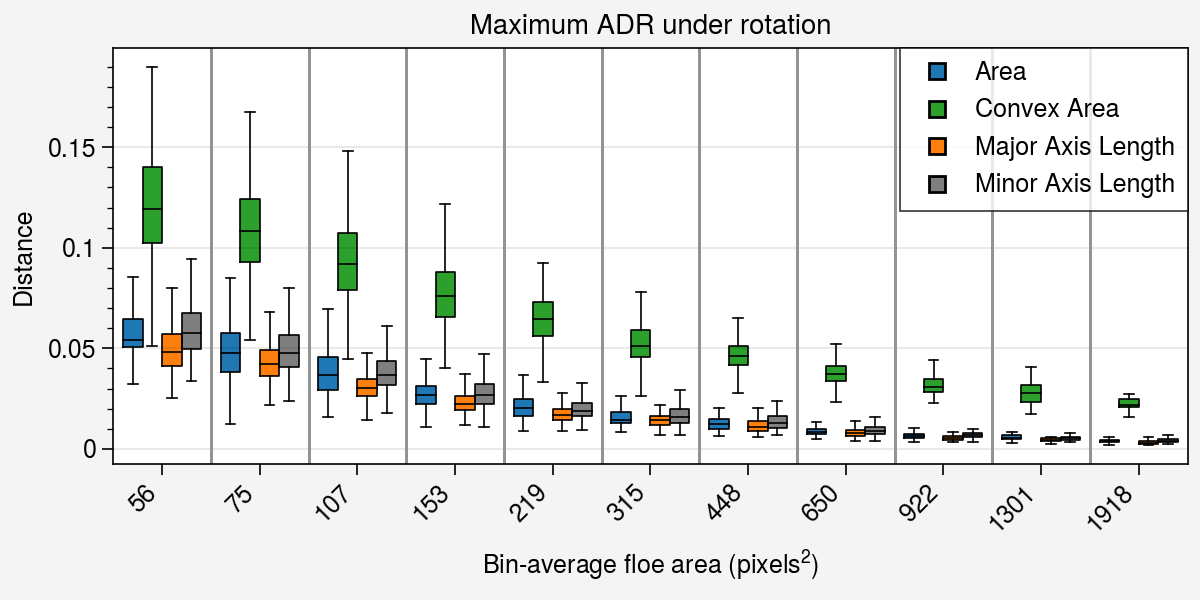

In [25]:
# could make this a function
df = df_rotation.copy()

bin_area_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']

fig, ax = pplt.subplots(width=6, height=3)
h = []
for var, color, offset in zip(['max_adr_area', 'max_adr_convex_area',
                       'max_adr_major_axis_length', 'max_adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray'],
                             np.linspace(-0.3, 0.3, 4)):
    plot_data = df.pivot_table(columns='area_bin', values=var, index=df.index)
    plot_data = plot_data.loc[:, bin_area_count['count'] > 20]
    x = plot_data.columns.astype(int)
    plot_data.columns = plot_data.columns + offset
    ax.box(plot_data, fillcolor=color, showfliers=False, widths=0.2)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))

    # Draw grid lines
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='gray')
        
ax.format(xtickminor=False, #xlocator=bin_area_ave.round().values.squeeze(),
          xlocator=x, xlim=(4.5, x.max()+0.5),
          xformatter=[str(int(x)) for x in bin_area_count.area.round().values.squeeze()], xrotation=45,
         title='Maximum ADR under rotation', xlabel='Bin-average floe area (pixels$^2$)', ylabel='ADR',
         xgrid=False)

ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length'], ncols=1)
fig.save('../figures/../figures/maximum_adr_rotation_boxplot.png', dpi=300)

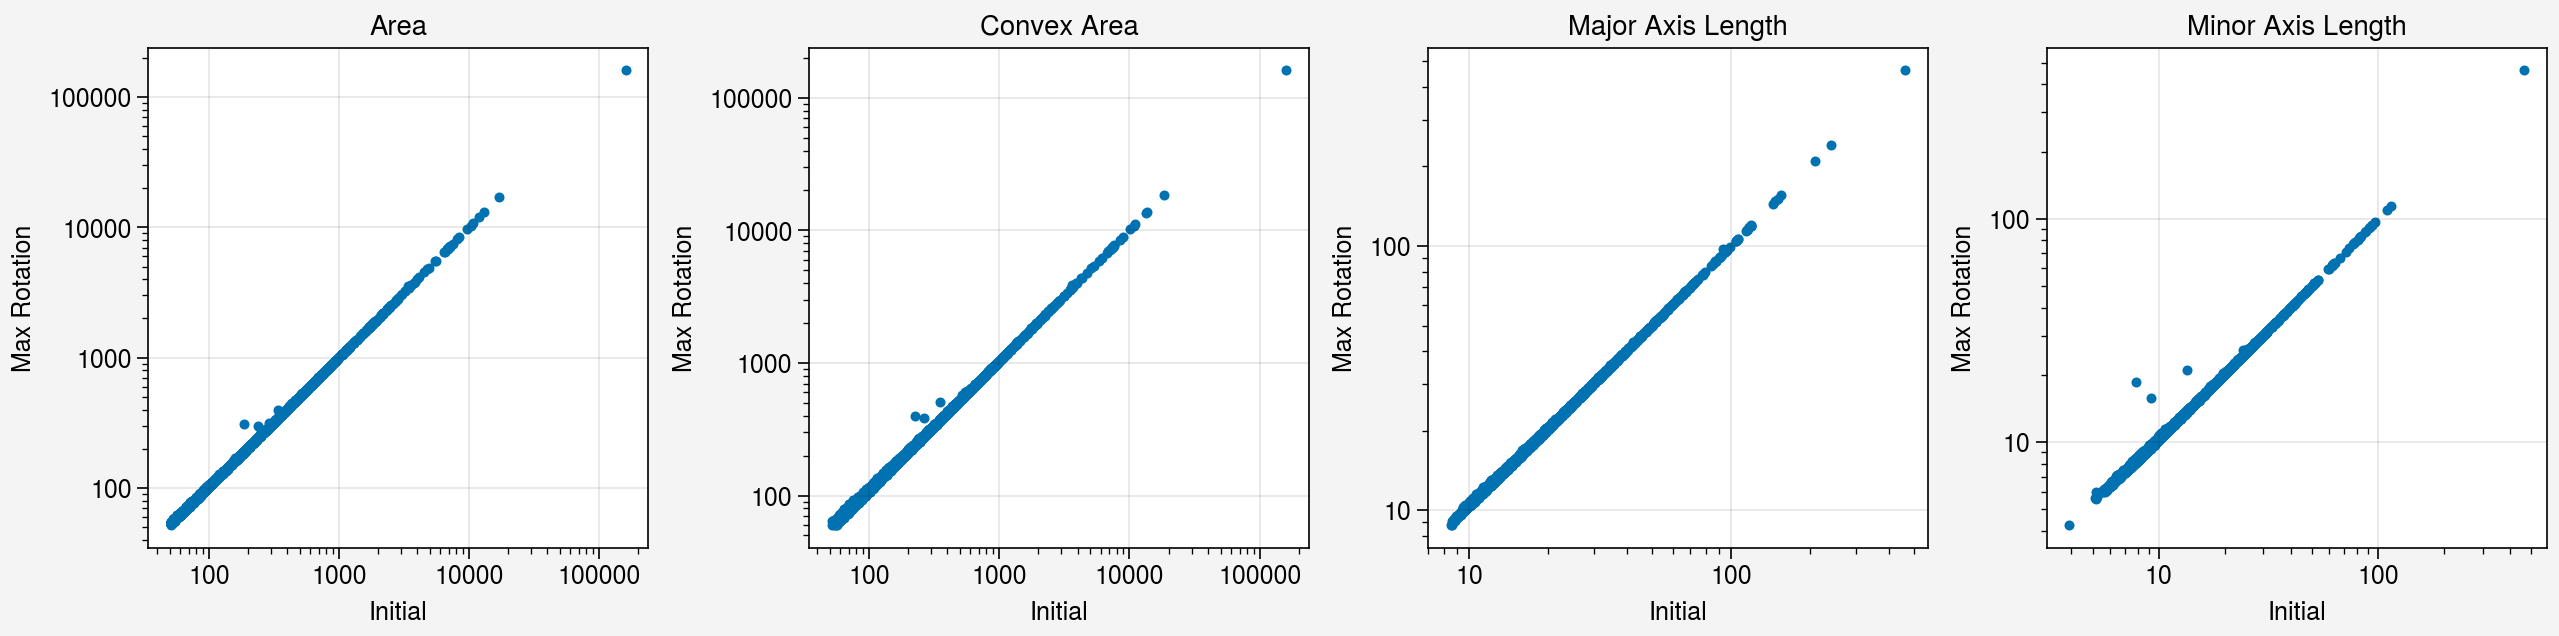

In [26]:
fig, axs = pplt.subplots(ncols=4, share=False)
for ax, var in zip(axs, ['area', 'convex_area', 'major_axis_length', 'minor_axis_length']):
    ax.scatter(df_rotation[var],
               df_rotation['max_' + var], m='.')
    ax.format(xlabel='Initial', ylabel='Max Rotation', title=var.replace('_', ' ').title(), xscale='log', yscale='log')
fig.save('../figures/scatter_comp_rotation_floes.png', dpi=300)

Estimating the upper bound implied by rotation uncertainty

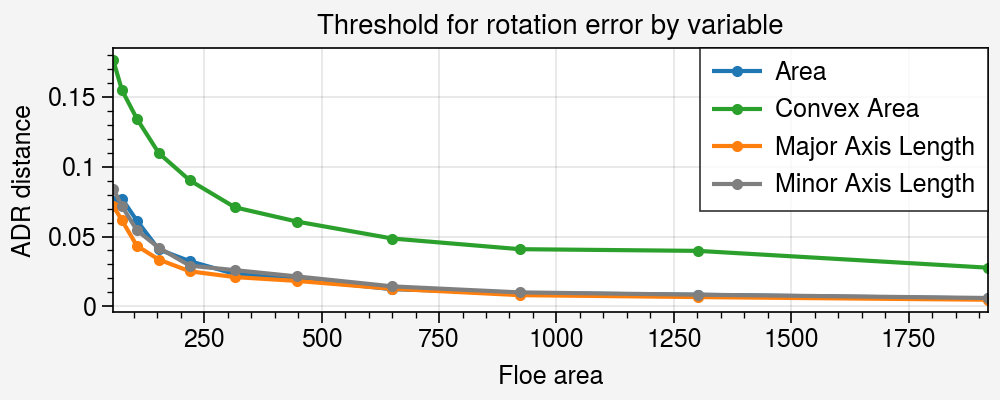

In [28]:
var = 'max_adr_area'
# standard log space bins
bins = np.logspace(1, 4, base=10, num=20)
df['area_bin'] = np.digitize(df['area'], bins)
bin_area_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']

df_filtered = df.groupby('area_bin').filter(lambda x: len(x) > 30)
thresh_results = {}
fig, ax = pplt.subplots(width=5, height=2)
h = []
for var, color in zip(['max_adr_area', 'max_adr_convex_area',
                       'max_adr_major_axis_length', 'max_adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray']):

    q = df_filtered[['area_bin', var]].groupby('area_bin').quantile([0.99, 0.75, 0.5, 0.25]).reset_index()
    q.rename({'level_1': 'percentile'}, axis=1, inplace=True)
    q = q.pivot_table(index='area_bin', columns='percentile', values=var)
    iqr = q[0.75] - q[0.25]
    thresh = q[0.5] + 1.5*iqr
    thresh_results[var] = pd.Series(thresh.values, index=bin_area_count.loc[thresh.index, 'area'].values)
    
    h.append(ax.plot(bin_area_count.loc[thresh.index, 'area'].values, thresh.values, marker='.', color=color, label=var))
ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length'], ncols=1)
ax.format(title='Threshold for rotation error by variable', ylabel='ADR distance', xlabel='Floe area')

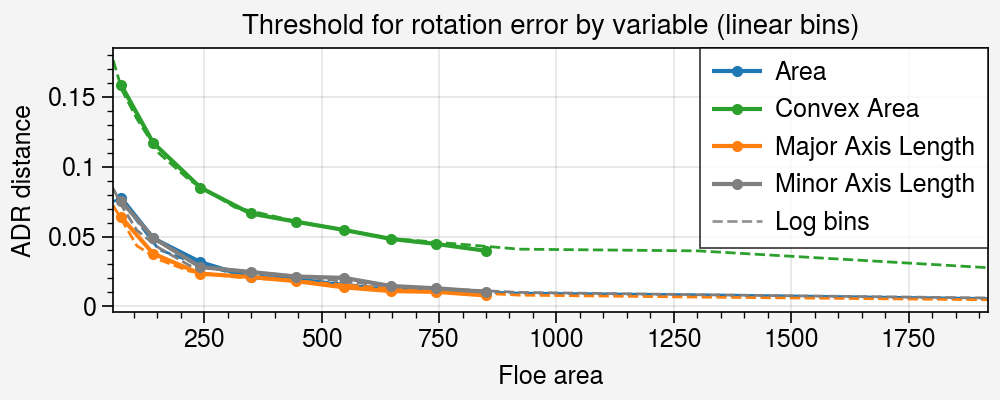

In [29]:
var = 'max_adr_area'
# standard log space bins
bins = np.arange(0, 10000, 100)
df['area_bin'] = np.digitize(df['area'], bins)
bin_area_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']

df_filtered = df.groupby('area_bin').filter(lambda x: len(x) > 30)

fig, ax = pplt.subplots(width=5, height=2)
h = []
for var, color in zip(['max_adr_area', 'max_adr_convex_area',
                       'max_adr_major_axis_length', 'max_adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray']):

    q = df_filtered[['area_bin', var]].groupby('area_bin').quantile([0.99, 0.75, 0.5, 0.25]).reset_index()
    q.rename({'level_1': 'percentile'}, axis=1, inplace=True)
    q = q.pivot_table(index='area_bin', columns='percentile', values=var)
    iqr = q[0.75] - q[0.25]
    thresh = q[0.5] + 1.5*iqr
    
    
    h.append(ax.plot(bin_area_count.loc[thresh.index, 'area'].values, thresh.values, marker='.', color=color, label=var))
    ax.plot(thresh_results[var], color=color, label='', ls='--', lw=1)
h.append(ax.plot([],[], ls='--', lw=1, color='gray'))
ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length', 'Log bins'], ncols=1)
ax.format(title='Threshold for rotation error by variable (linear bins)', ylabel='ADR distance', xlabel='Floe area')

# Matched pairs experiment

In [30]:
#### Load the data both for the matches and for the inital images #####
dataloc = '../../eval_seg/data/floe_property_tables/matched/'
files = os.listdir(dataloc)
data = []
for f in files:
    if '.csv' in f:
        data.append(pd.read_csv(dataloc + f))
df_matched = pd.concat(data)
dataloc = '../../eval_seg/data/floe_property_tables/aqua/'
files = os.listdir(dataloc)
data = []
for f in files:
    if '.csv' in f:
        data.append(pd.read_csv(dataloc + f))
df_aqua = pd.concat(data)
dataloc = '../../eval_seg/data/floe_property_tables/terra/'
files = os.listdir(dataloc)
data = []
for f in files:
    if '.csv' in f:
        data.append(pd.read_csv(dataloc + f))
df_terra = pd.concat(data)

df_matched = df_matched.dropna()
df_matched['case_number'] = [str(int(x)).zfill(3) for x in df_matched['case_number']]
df_terra['case_number'] = [str(int(x)).zfill(3) for x in df_terra['case_number']]
df_aqua['case_number'] = [str(int(x)).zfill(3) for x in df_aqua['case_number']]

df_merged = df_matched.merge(df_aqua[['label', 'case_number', 'axis_major_length', 'axis_minor_length', 'convex_area']], 
                 left_on=['aqua_label', 'case_number'], right_on=['label', 'case_number'],
                 suffixes=[None, '_aqua'], how='inner').merge(
    df_terra[['label', 'case_number', 'axis_major_length', 'axis_minor_length', 'convex_area']], 
                 left_on=['terra_label', 'case_number'], right_on=['label', 'case_number'],
                 suffixes=[None, '_terra'], how='inner')
df_merged.rename({'axis_major_length': 'axis_major_length_aqua',
                  'axis_minor_length': 'axis_minor_length_aqua',
                  'aqua_area': 'area_aqua',
                  'terra_area': 'area_terra',
                  'convex_area': 'convex_area_aqua'}, axis=1, inplace=True)


/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_91510/1830507418.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aqua = pd.concat(data)
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_91510/1830507418.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_terra = pd.concat(data)


In [34]:
df_merged

,Unnamed: 0,aqua_label,terra_label,area_aqua,area_terra,joint_area,iou,r_aqua,c_aqua,r_terra,...,case_number,method,label,axis_major_length_aqua,axis_minor_length_aqua,convex_area_aqua,label_terra,axis_major_length_terra,axis_minor_length_terra,convex_area_terra
0,5,29.0,5.0,202.0,219.0,47.0,0.125668,183.594059,29.970297,192.872146,...,155,low_iou_manual,29,19.225450,13.637770,218.0,5,19.311145,14.884422,232.0
1,1,2.0,1.0,76.0,69.0,65.0,0.812500,10.276316,98.000000,10.710145,...,108,high_iou,2,11.394912,8.515476,83.0,1,10.662496,8.238917,73.0
2,0,1.0,2.0,57.0,46.0,46.0,0.807018,8.807018,150.315789,9.130435,...,108,high_iou,1,8.964979,8.119663,59.0,2,8.537692,6.804873,48.0
3,2,3.0,5.0,1059.0,964.0,936.0,0.861086,29.083097,356.373938,28.447095,...,108,high_iou,3,41.147520,33.626137,1099.0,5,38.331426,32.595499,999.0
4,3,4.0,6.0,91.0,70.0,68.0,0.731183,20.241758,243.527473,19.828571,...,108,high_iou,4,13.695746,8.598886,95.0,6,11.854313,7.623016,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,9,10.0,11.0,1154.0,1135.0,933.0,0.688053,223.806759,317.609185,220.212335,...,100,high_iou,10,79.322036,21.132972,1349.0,11,76.887094,21.514218,1308.0
1109,11,12.0,12.0,700.0,608.0,540.0,0.703125,314.242857,54.197143,312.761513,...,100,high_iou,12,46.523676,21.254762,810.0,12,48.156079,17.187424,681.0
1110,12,13.0,13.0,109.0,117.0,69.0,0.439490,334.669725,95.642202,333.564103,...,100,high_iou,13,17.679270,8.251676,121.0,13,19.572077,8.151744,136.0
1111,0,2.0,3.0,129.0,181.0,126.0,0.684783,374.666667,362.224806,375.574586,...,046,high_iou,2,14.348419,11.612679,134.0,3,15.789117,15.000046,191.0


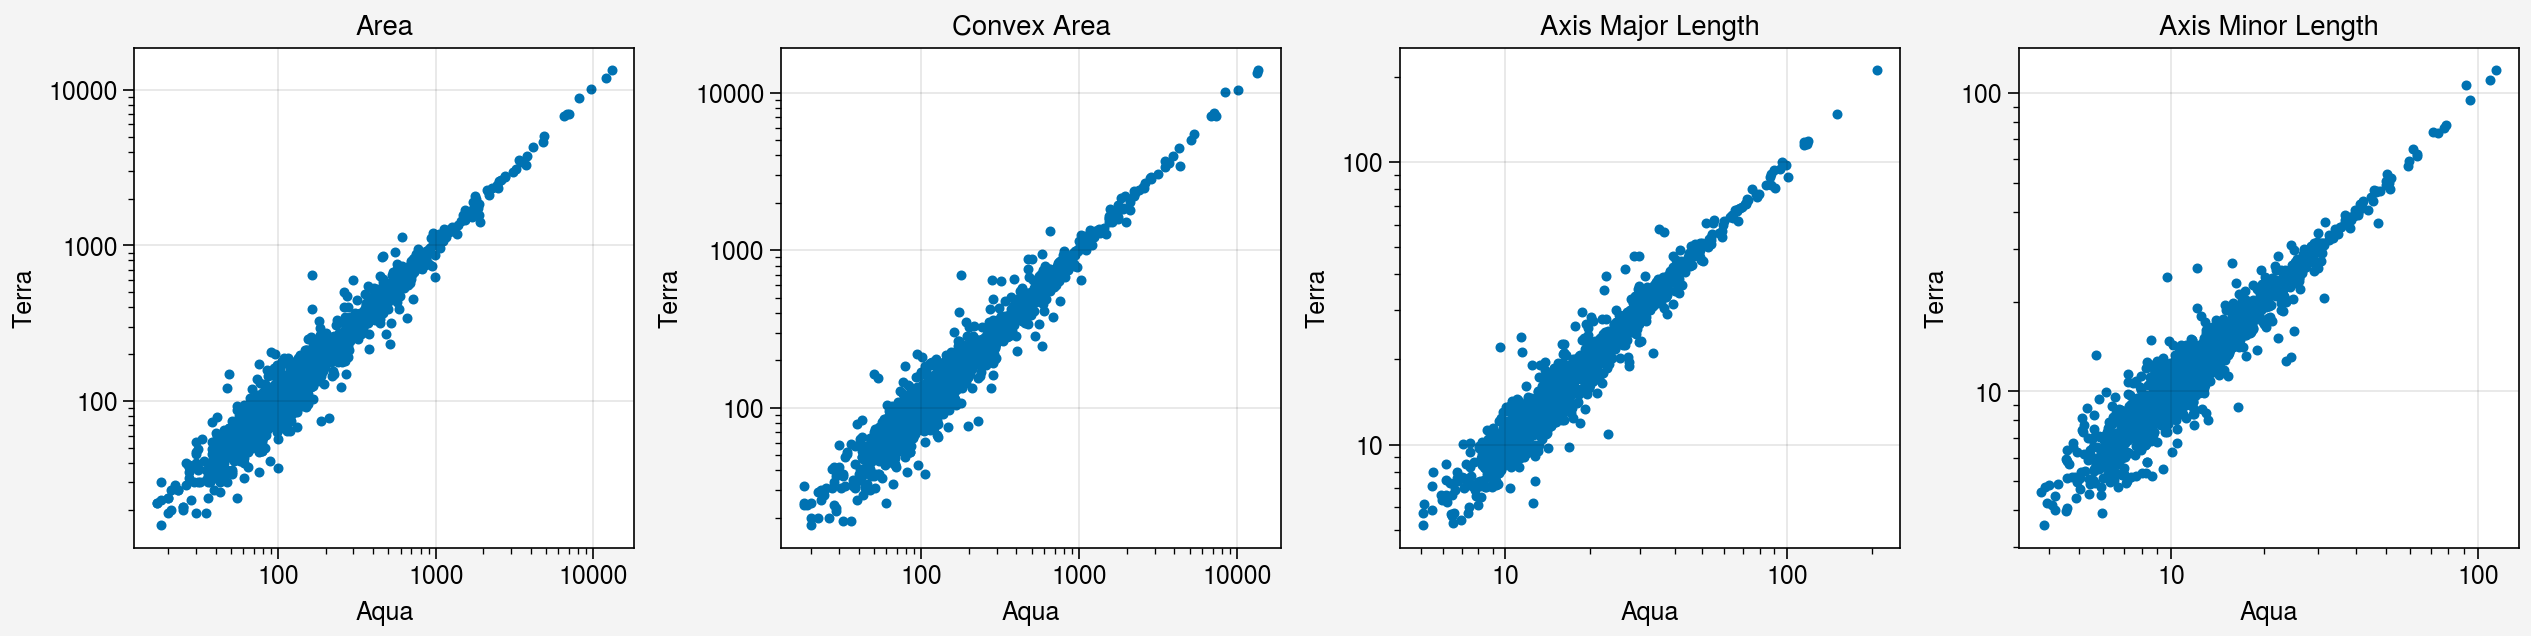

In [31]:
fig, axs = pplt.subplots(ncols=4, share=False)
for ax, var in zip(axs, ['area', 'convex_area', 'axis_major_length', 'axis_minor_length']):
    ax.scatter(df_merged[var + '_aqua'],
               df_merged[var + '_terra'], m='.')
    ax.format(xlabel='Aqua', ylabel='Terra', title=var.replace('_', ' ').title())
axs.format(yscale='log', xscale='log')
fig.save('../figures/scatter_comp_matched_floes.png', dpi=300)

In [35]:
df_merged['adr_area'] = 2*np.abs(df_merged['area_aqua'] - df_merged['area_terra'])/(df_merged['area_aqua'] + df_merged['area_terra'])
df_merged['adr_major_axis_length'] = 2*np.abs(df_merged['axis_major_length_aqua'] - df_merged['axis_major_length_terra'])/(df_merged['axis_major_length_aqua'] + df_merged['axis_major_length_terra'])
df_merged['adr_minor_axis_length'] = 2*np.abs(df_merged['axis_minor_length_aqua'] - df_merged['axis_minor_length_terra'])/(df_merged['axis_minor_length_aqua'] + df_merged['axis_minor_length_terra'])
df_merged['adr_convex_area'] = 2*np.abs(df_merged['convex_area_aqua'] - df_merged['convex_area_terra'])/(df_merged['convex_area_aqua'] + df_merged['convex_area_terra'])

bins = np.logspace(1, 4, base=10, num=20)

df_merged['area'] = 1/2*(df_merged['area_aqua'] + df_merged['area_terra'])
df_merged['area_bin'] = np.digitize(df_merged['area'], bins)
df_merged = df_merged.loc[df_merged.area > 50].copy()
bin_area_count = df_merged[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df_merged[['area_bin', 'area']].groupby('area_bin').count()['area']


The lower bins may be too narrow for the randomization experiment: many floe pairs fall into different bins. If I want to mimic the true pairings, what's the best strategy? 

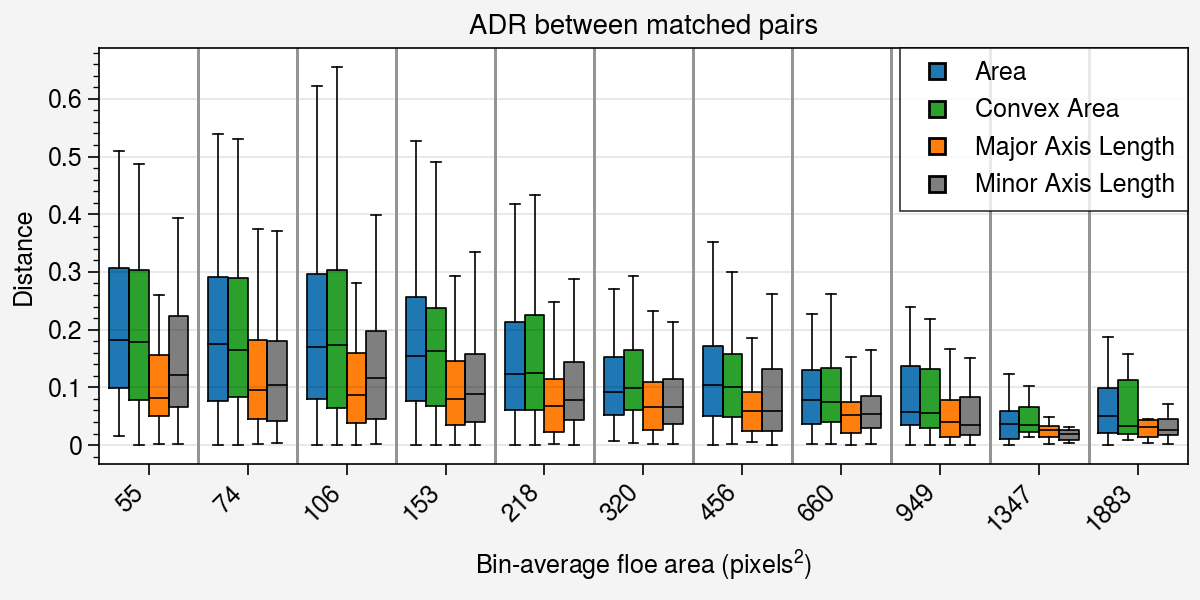

In [36]:
fig, ax = pplt.subplots(width=6, height=3)
h = []
df = df_merged.copy()
bin_area_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']
for var, color, offset in zip(['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray'],
                             np.linspace(-0.3, 0.3, 4)):
    plot_data = df.pivot_table(columns='area_bin', values=var, index=df.index)
    # bin_area_ave = df[['area_bin', 'area']].groupby('area_bin').mean()
    plot_data = plot_data.loc[:, bin_area_count['count'] > 10]
    x = plot_data.columns.astype(int)
    plot_data.columns = plot_data.columns + offset
    ax.box(plot_data, fillcolor=color, showfliers=False, widths=0.2)
    # ax.plot(plot_data.columns, df[['area_bin', var]].groupby('area_bin').median(), color=color, zorder=0)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='gray')
ax.format(xtickminor=False, #xlocator=bin_area_ave.round().values.squeeze(),
          xlocator=x, xlim=(4.5, x.max()+0.5),
          xformatter=[str(int(x)) for x in bin_area_count.area.round().values.squeeze()], xrotation=45,
         title='ADR between matched pairs', xlabel='Bin-average floe area (pixels$^2$)', ylabel='Distance',
         xgrid=False)

ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length'], ncols=1)
fig.save('../figures/../figures/adr_matched_boxplot.png', dpi=300)

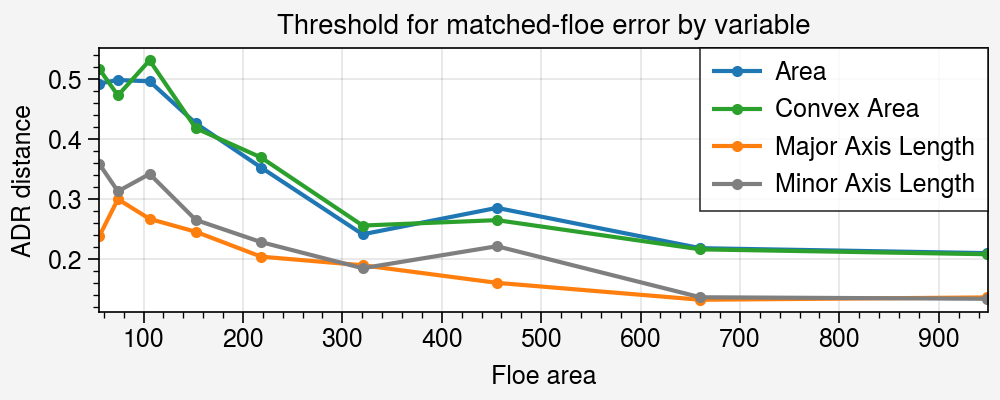

In [37]:
var = 'max_adr_area'
# standard log space bins
bins = np.logspace(1, 4, base=10, num=20)
df = df_merged.copy()
df['area_bin'] = np.digitize(df['area'], bins)
bin_area_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']

df_filtered = df.groupby('area_bin').filter(lambda x: len(x) > 30)
thresh_results = {}
fig, ax = pplt.subplots(width=5, height=2)
h = []
for var, color in zip(['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray']):

    q = df_filtered[['area_bin', var]].groupby('area_bin').quantile([0.99, 0.75, 0.5, 0.25]).reset_index()
    q.rename({'level_1': 'percentile'}, axis=1, inplace=True)
    q = q.pivot_table(index='area_bin', columns='percentile', values=var)
    iqr = q[0.75] - q[0.25]
    thresh = q[0.5] + 1.5*iqr
    thresh_results[var] = pd.Series(thresh.values, index=bin_area_count.loc[thresh.index, 'area'].values)
    
    h.append(ax.plot(bin_area_count.loc[thresh.index, 'area'].values, thresh.values, marker='.', color=color, label=var))
ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length'], ncols=1)
ax.format(title='Threshold for matched-floe error by variable', ylabel='ADR distance', xlabel='Floe area')

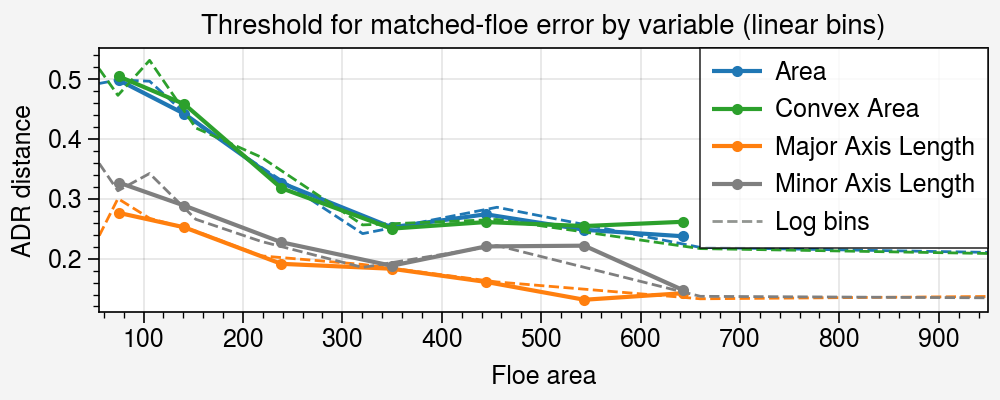

In [38]:
var = 'max_adr_area'
# standard log space bins
bins = np.arange(0, 10000, 100)
df = df_merged.copy()
df['area_bin'] = np.digitize(df['area'], bins)
bin_area_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']

df_filtered = df.groupby('area_bin').filter(lambda x: len(x) > 30)

fig, ax = pplt.subplots(width=5, height=2)
h = []
for var, color in zip(['adr_area', 'adr_convex_area',
                       'adr_major_axis_length', 'adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray']):

    q = df_filtered[['area_bin', var]].groupby('area_bin').quantile([0.99, 0.75, 0.5, 0.25]).reset_index()
    q.rename({'level_1': 'percentile'}, axis=1, inplace=True)
    q = q.pivot_table(index='area_bin', columns='percentile', values=var)
    iqr = q[0.75] - q[0.25]
    thresh = q[0.5] + 1.5*iqr
    
    
    h.append(ax.plot(bin_area_count.loc[thresh.index, 'area'].values, thresh.values, marker='.', color=color, label=var))
    ax.plot(thresh_results[var], color=color, label='', ls='--', lw=1)
h.append(ax.plot([],[], ls='--', lw=1, color='gray'))
ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length', 'Log bins'], ncols=1)
ax.format(title='Threshold for matched-floe error by variable (linear bins)', ylabel='ADR distance', xlabel='Floe area')

# Unmatched pairs experiment
We test the background variability of the floe metrics by looking at pairs that are known not to be matches. We select all the Aqua image, then, within each area bin, we find the full list of combinations (possible pairs, no repeats, order doesn't matter), and draw a sample of 1000 of each of the random pairs. Then, we compute the ADR between each pair.

In [39]:
import itertools
import numpy as np

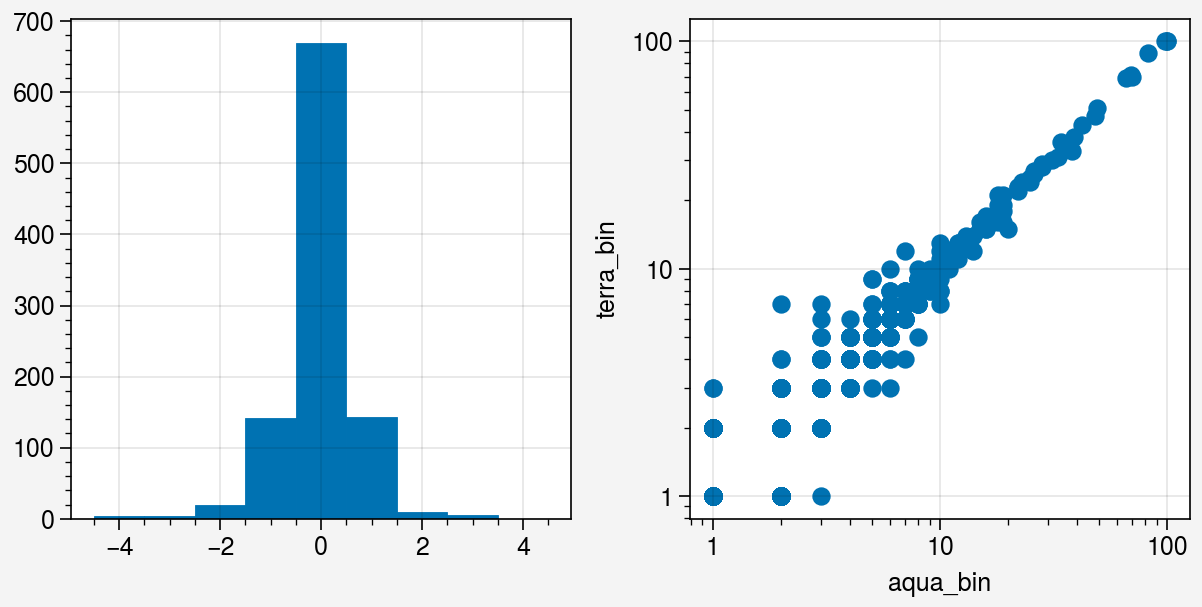

In [40]:
df_merged['aqua_bin'] = np.digitize(df_merged['area_aqua'], bins)
df_merged['terra_bin'] = np.digitize(df_merged['area_terra'], bins)

fig, ax = pplt.subplots(ncols=2, share=False)
ax[0].hist(df_merged['aqua_bin'] - df_merged['terra_bin'], bins=np.arange(-4.5, 4.6, 1))
ax[1].scatter(df_merged['aqua_bin'], df_merged['terra_bin'])
ax[1].format(yscale='log', xscale='log')

In [41]:
df_aqua['floe_id'] = [cn + '_' + str(int(lb)).zfill(3) for cn, lb in zip(df_aqua['case_number'],
                                                                         df_aqua['label'])]
df_aqua.set_index('floe_id', drop=True, inplace=True)
bins = np.logspace(1, 4, base=10, num=20)
df_aqua['area_bins'] = np.digitize(df_aqua['area'], bins)

In [42]:
# Method 1: keep it within bins
def adr(d1, d2, v):
    return 2*np.abs(d1[v].values - d2[v].values)/(d1[v].values + d2[v].values)

results = []
for bn, data in df_aqua.groupby('area_bins'):
    if data.area.min() > 50:
        if len(data) > 20:
            c = itertools.combinations(data.index, 2)
            rng = np.random.default_rng(seed=5 + bn)
            n = 1000
            pairs = rng.choice(list(c), n)
            f = pairs[:,0]
            g = pairs[:, 1]
            results.append(
                pd.DataFrame(
                    {'adr_area': np.round(adr(data.loc[f], data.loc[g], 'area'), 4),
                     'adr_convex_area':  np.round(adr(data.loc[f], data.loc[g], 'convex_area'), 4),
                     'adr_major_axis_length':  np.round(adr(data.loc[f], data.loc[g], 'axis_major_length'), 4),
                     'adr_minor_axis_length': np.round(adr(data.loc[f], data.loc[g], 'axis_minor_length'), 4),
                     'area_first': data.loc[f, 'area'].values,
                     'area_second': data.loc[g, 'area'].values,
                     'area': 1/2*(data.loc[f, 'area'].values + data.loc[g, 'area'].values),
                     'area_bin': bn}
                ))
df_random = pd.concat(results)  

In [43]:
def adr(d1, d2, v):
    return 2*np.abs(d1[v].values - d2[v].values)/(d1[v].values + d2[v].values)

results = []
for bn, data_bn in df_aqua.groupby('area_bins'):
    data = df_aqua.loc[df_aqua.area_bins.between(bn-2, bn+2)]
    print(bn,  len(data_bn), len(data))
    if data.area.min() > 50:
        if len(data) > 20:
            c = itertools.combinations(data.index, 2)
            rng = np.random.default_rng(seed=5 + bn)
            n = 1000
            pairs = rng.choice(list(c), n)
            f = pairs[:,0]
            g = pairs[:, 1]
            results.append(
                pd.DataFrame(
                    {'adr_area': np.round(adr(data.loc[f], data.loc[g], 'area'), 4),
                     'adr_convex_area':  np.round(adr(data.loc[f], data.loc[g], 'convex_area'), 4),
                     'adr_major_axis_length':  np.round(adr(data.loc[f], data.loc[g], 'axis_major_length'), 4),
                     'adr_minor_axis_length': np.round(adr(data.loc[f], data.loc[g], 'axis_minor_length'), 4),
                     'area_first': data.loc[f, 'area'].values,
                     'area_second': data.loc[g, 'area'].values,
                     'area': 1/2*(data.loc[f, 'area'].values + data.loc[g, 'area'].values),
                     'area_bin': bn}
                ))
df_random = pd.concat(results)  

1 9 146
2 38 388
3 99 746
4 242 1136
5 358 1434
6 399 1653
7 336 1633
8 318 1426
9 222 1177
10 151 943
11 150 667
12 102 469
13 42 338
14 24 198
15 20 104
16 10 65
17 8 44
18 3 26
19 3 16
20 2 8


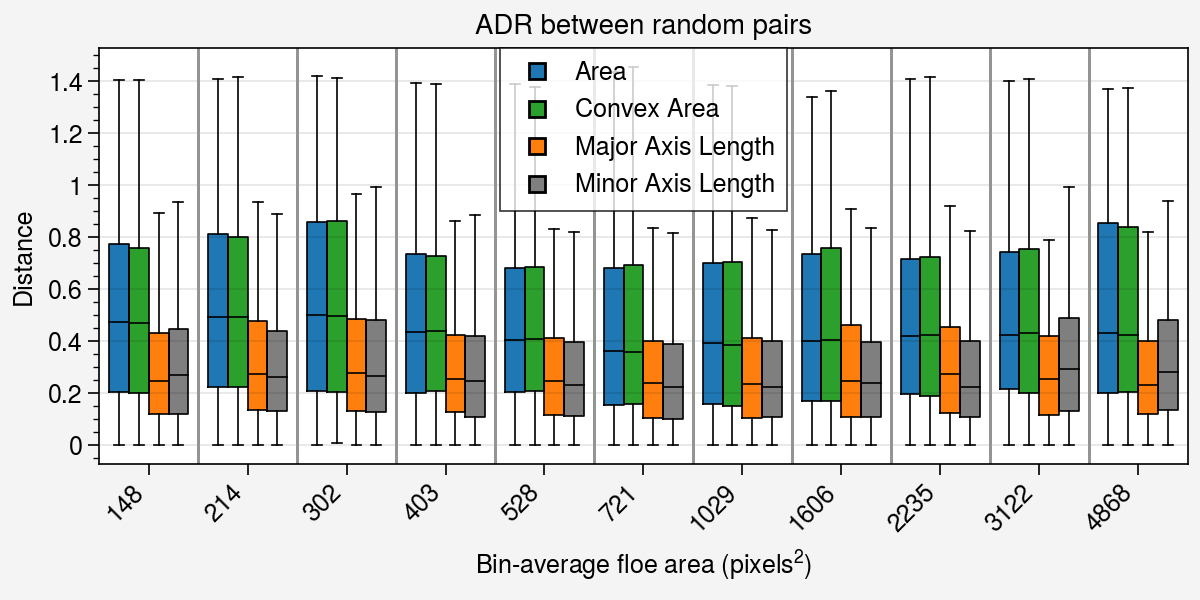

In [44]:
fig, ax = pplt.subplots(width=6, height=3)
h = []
df = df_random.copy()
bin_area_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']

for var, color, offset in zip(['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray'],
                             np.linspace(-0.3, 0.3, 4)):
    plot_data = df.pivot_table(columns='area_bin', values=var, index=df.index)
    x = plot_data.columns.astype(int)
    plot_data.columns = plot_data.columns + offset
    ax.box(plot_data, fillcolor=color, showfliers=False, widths=0.2)
    # ax.plot(plot_data.columns, df[['area_bin', var]].groupby('area_bin').median(), color=color, zorder=0)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='gray')
ax.format(xtickminor=False, #xlocator=bin_area_ave.round().values.squeeze(),
          xlocator=x, xlim=(7.5, x.max()+0.5),
          xformatter=[str(int(x)) for x in bin_area_count.area.round().values.squeeze()], xrotation=45,
         title='ADR between random pairs', xlabel='Bin-average floe area (pixels$^2$)', ylabel='Distance',
         xgrid=False)

ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length'], ncols=1)
fig.save('../figures/../figures/adr_random_boxplot.png', dpi=300)

Finally, we overlay the matched pair results on the random pair results.

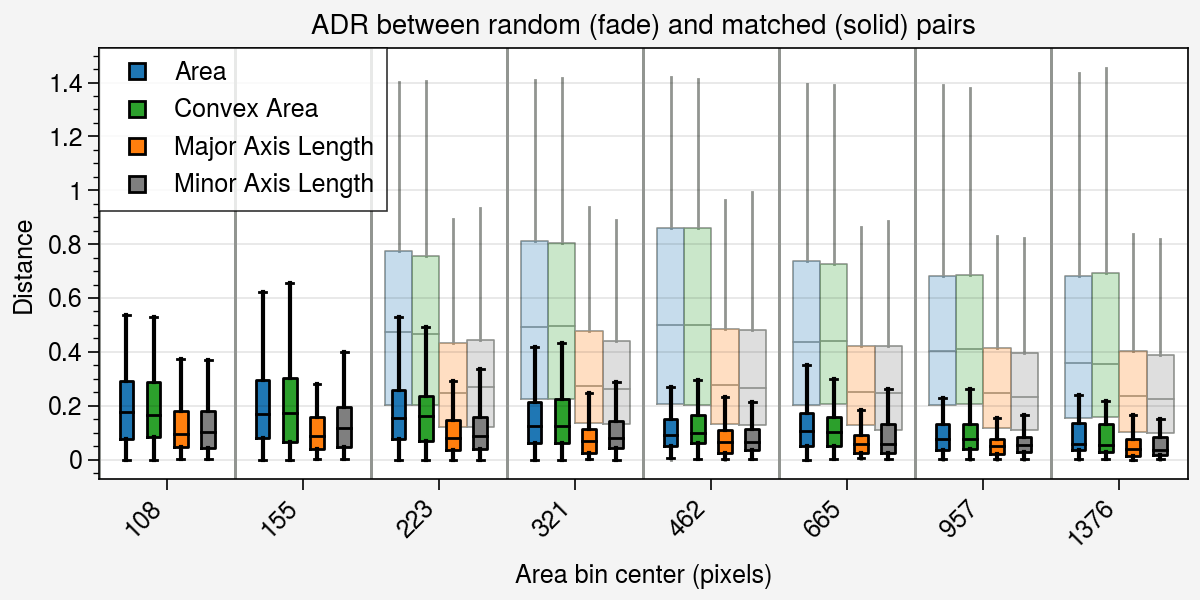

In [45]:
bcenter = 0.5*(bins[1:] + bins[:-1])

fig, ax = pplt.subplots(width=6, height=3)
h = []
df = df_random.copy()
bin_area_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']

for var, color, offset in zip(['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray'],
                             np.linspace(-0.3, 0.3, 4)):
    plot_data = df.pivot_table(columns='area_bin', values=var, index=df.index)
    x = plot_data.columns.astype(int)
    plot_data.columns = plot_data.columns + offset
    ax.box(plot_data, fillcolor=color, showfliers=False, whiskerlinewidths=1
           , ec='gray', caplinewidths=0,
           widths=0.2, alpha=0.25, zorder=0)
    # ax.plot(plot_data.columns, df[['area_bin', var]].groupby('area_bin').median(), color=color, zorder=0)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='light gray')

df = df_merged.copy()
df = df.loc[df.area > 50]
bin_area_count = df[['area_bin', 'area']].groupby('area_bin').mean()
bin_area_count['count'] = df[['area_bin', 'area']].groupby('area_bin').count()['area']

for var, color, offset in zip(['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray'],
                             np.linspace(-0.3, 0.3, 4)):
    plot_data = df.pivot_table(columns='area_bin', values=var, index=df.index)
    plot_data = plot_data.loc[:, bin_area_count['count'] > 20]
    x = plot_data.columns.astype(int)
    plot_data.columns = plot_data.columns + offset
    ax.box(plot_data, fillcolor=color, showfliers=False, widths=0.1, zorder=5, lw=1, whiskerlinewidth=1.5)
    # ax.plot(plot_data.columns, df[['area_bin', var]].groupby('area_bin').median(), color=color, zorder=0)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='gray')
        
ax.format(xtickminor=False, #xlocator=bin_area_ave.round().values.squeeze(),
          xlocator=x, xlim=(5.5, x.max()+0.5),
          xformatter=[str(int(x)) for x in np.round(bcenter[bin_area_count[bin_area_count['count'] > 20].index])], xrotation=45,
         title='ADR between random (fade) and matched (solid) pairs',
          xlabel='Area bin center (pixels)', ylabel='Distance',
         xgrid=False)

ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length'], ncols=1)
fig.save('../figures/../figures/adr_merged_random_boxplot.png', dpi=300)

# Summary of tests.
## Rotation errors
The error in ADR measurements due to rotation rate is fairly small, except in the case of convex area. For convex area, median error decreases from 12 to 2.5% as the floe area increases from 50 to over 1200 pixels. Values larger than 15% are possible for floes smaller than 100 pixels. For the other three measurements (area, major axis length, minor axis length), median error decreases from around 8% to less than 1%. 

## Inter-image variation errors
Errors due to differences in best-estimate manual outlines of paired floes give an indication of errors due to the uncertainty in the floe shape. Differences in illumination, cloud cover, and ice compactness affect the accuracy of manual floe identification. The ADR values are much larger for the matched pairs than for the rotated floes, telling us that differences in the appearance of floes from image to image is a larger source of uncertainty than difference in floe orientation. Measures of axis length show smaller ADR values than do the area measures. Both decrease is floe size increases.

## Random errors
Randomly pairing objects within area bins results in nearly constant distributions with area. The matched pair distributions of area, strangely enough, show larger differences than the random pairs. Only with large floes do the differences seem noticebly smaller than the random variations. 

# Finding best-performing thresholds
We can think of this in terms of precision and recall: for each possible threshold, we end up labeling pairings as candidates and non-candidates. A false positive is a candidate that is not a true match, a false negative is rejecting a true match. With 4 metrics, should it be done one at a time? Or with all simultaneously? How sensitive is the final choice?


In [34]:
area_threshold = 0.24
# precision = true positives / (true positives + false positives)
# recall = true positives / (true positives + false negatives)

In [35]:
df_merged['true_match'] = True
df_random['true_match'] = False
df_all = pd.concat([df_random[['area', 'adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length', 'true_match']],
                    df_merged[['area', 'adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length', 'true_match']]])

In [36]:
df_random.columns

Index(['adr_area', 'adr_convex_area', 'adr_major_axis_length',
       'adr_minor_axis_length', 'area_first', 'area_second', 'area',
       'area_bin', 'true_match'],
      dtype='object')

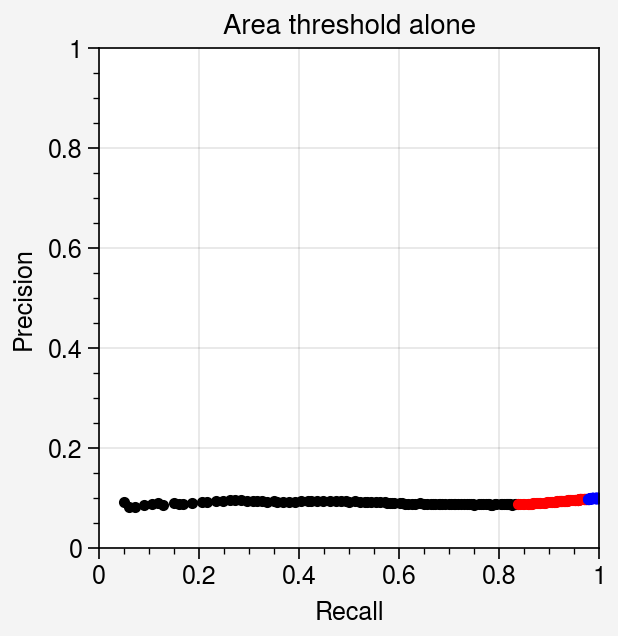

In [37]:
fig, ax = pplt.subplots()
for area_threshold in np.linspace(0.01, 0.3, 100):
    test_result = df_all['adr_area'] < area_threshold
    truth = df_all['true_match']
    precision = np.sum(test_result & truth) / np.sum(test_result)
    recall = np.sum(test_result & truth) / np.sum(truth)
    ax.plot(recall, precision, marker='.', color='k')
for area_threshold in np.linspace(0.3, 0.6, 100):
    test_result = df_all['adr_area'] < area_threshold
    truth = df_all['true_match']
    precision = np.sum(test_result & truth) / np.sum(test_result)
    recall = np.sum(test_result & truth) / np.sum(truth)
    ax.plot(recall, precision, marker='.', color='r')
for area_threshold in np.linspace(0.6, 1, 100):
    test_result = df_all['adr_area'] < area_threshold
    truth = df_all['true_match']
    precision = np.sum(test_result & truth) / np.sum(test_result)
    recall = np.sum(test_result & truth) / np.sum(truth)
    ax.plot(recall, precision, marker='.', color='b')
ax.format(ylim=(0, 1), xlim=(0, 1))
ax.format(ylabel='Precision', xlabel='Recall', title='Area threshold alone')

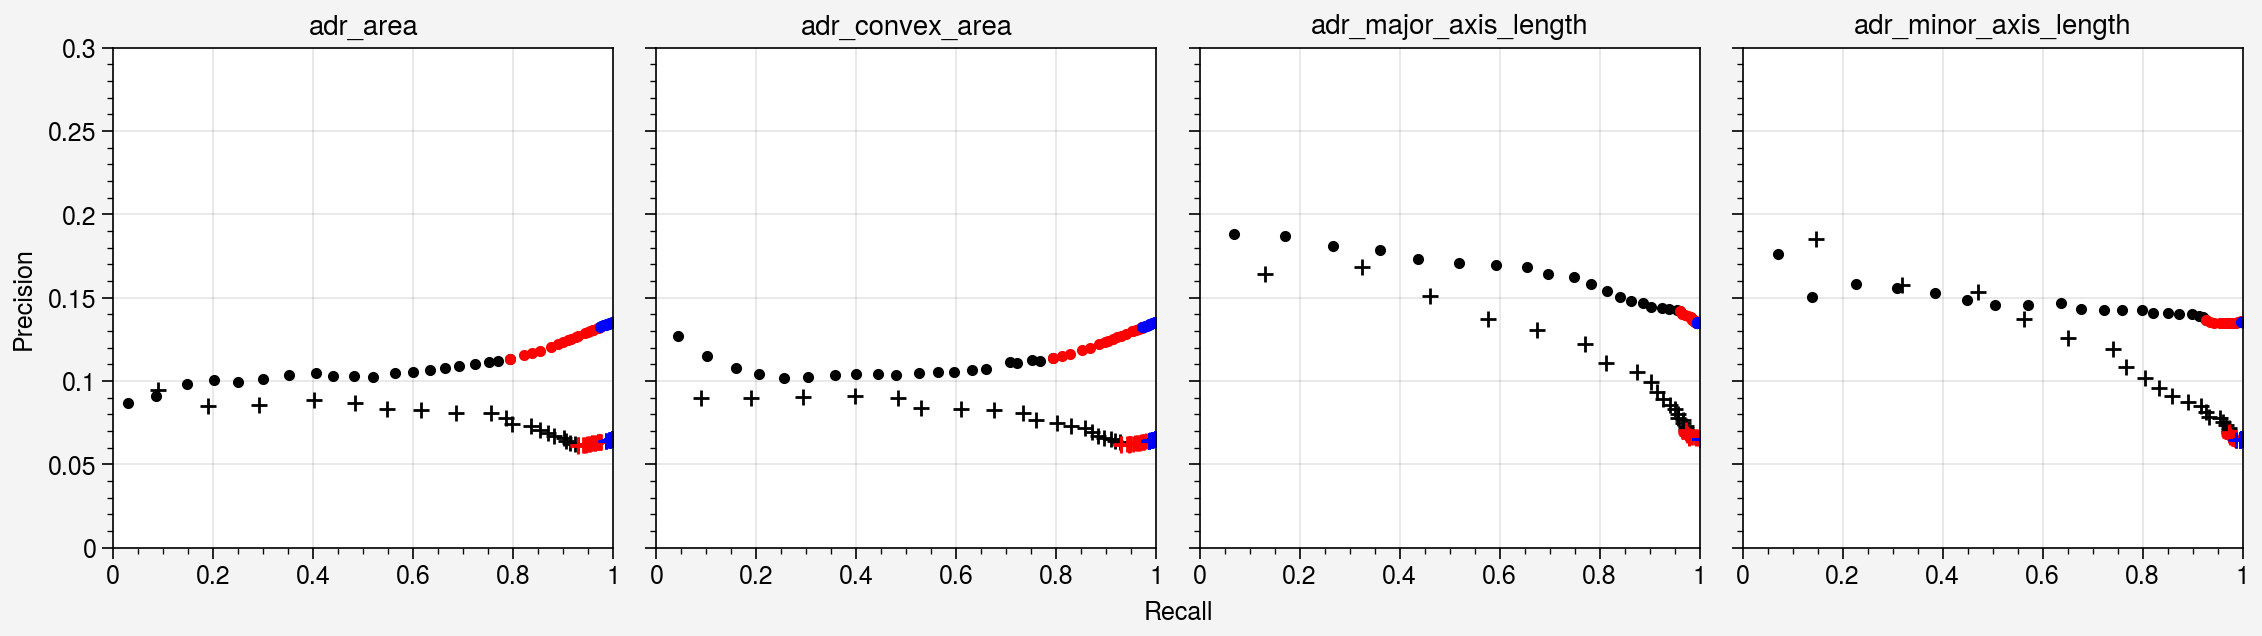

In [38]:
fig, axs = pplt.subplots(ncols=4)
idx = df_all.area < 300
for ax, var in zip(axs, ['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length']):
    for area_threshold in np.linspace(0.01, 0.3, 20):
        test_result = df_all.loc[idx, var] < area_threshold
        truth = df_all.loc[idx, 'true_match']
        precision = np.sum(test_result & truth) / np.sum(test_result)
        recall = np.sum(test_result & truth) / np.sum(truth)
        ax.plot(recall, precision, marker='.', color='k')
    for area_threshold in np.linspace(0.3, 0.6, 20):
        test_result = df_all.loc[idx, var] < area_threshold
        truth = df_all.loc[idx, 'true_match']
        precision = np.sum(test_result & truth) / np.sum(test_result)
        recall = np.sum(test_result & truth) / np.sum(truth)
        ax.plot(recall, precision, marker='.', color='r')
    for area_threshold in np.linspace(0.6, 1, 20):
        test_result = df_all.loc[idx, var] < area_threshold
        truth = df_all.loc[idx, 'true_match']
        precision = np.sum(test_result & truth) / np.sum(test_result)
        recall = np.sum(test_result & truth) / np.sum(truth)
        ax.plot(recall, precision, marker='.', color='b')
    ax.format(ylim=(0, 1), xlim=(0, 1))
    ax.format(ylabel='Precision', xlabel='Recall', title=var)

idx = df_all.area > 300
for ax, var in zip(axs, ['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length']):
    for area_threshold in np.linspace(0.01, 0.3, 20):
        test_result = df_all.loc[idx, var] < area_threshold
        truth = df_all.loc[idx, 'true_match']
        precision = np.sum(test_result & truth) / np.sum(test_result)
        recall = np.sum(test_result & truth) / np.sum(truth)
        ax.plot(recall, precision, marker='+', color='k')
    for area_threshold in np.linspace(0.3, 0.6, 20):
        test_result = df_all.loc[idx, var] < area_threshold
        truth = df_all.loc[idx, 'true_match']
        precision = np.sum(test_result & truth) / np.sum(test_result)
        recall = np.sum(test_result & truth) / np.sum(truth)
        ax.plot(recall, precision, marker='+', color='r')
    for area_threshold in np.linspace(0.6, 1, 20):
        test_result = df_all.loc[idx, var] < area_threshold
        truth = df_all.loc[idx, 'true_match']
        precision = np.sum(test_result & truth) / np.sum(test_result)
        recall = np.sum(test_result & truth) / np.sum(truth)
        ax.plot(recall, precision, marker='+', color='b')
    ax.format(ylim=(0, .3), xlim=(0, 1))
    ax.format(ylabel='Precision', xlabel='Recall', title=var)

## Quick notes:
- Circles: small floes. Crosses: large floes
- Black: low thresholds; Red: medium (0.3 to 0.6), Blue: high (0.6 to 1)
- Here, it's all real floe shapes -- the tests may do well at filtering out unrealistic shapes
- Precision is low in all cases. Only minor improvements in precision, while the whole range or recall is possible
- Individual thresholds are not very effective at filtering out bad matches. Possible that a combination of the thresholds is good, though.

In [50]:
import scipy.stats as stats

data = df_all.loc[df_all.true_match, :]
results = []
done = []
for var1 in ['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length']:
    for var2 in ['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length']:
        if var1 != var2:
            pair = [var1, var2]
            pair.sort()
                
            if pair not in done:
                r = stats.pearsonr(data[var1], data[var2])
                c1, c2 = np.round(r.confidence_interval(), 2)
                results.append(['tp', var1, var2, np.round(r.statistic, 2), c1, c2])
                done.append(pair)
data = df_all.loc[~df_all.true_match, :]
done = []
for var1 in ['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length']:
    for var2 in ['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length']:
        if var1 != var2:
            pair = [var1, var2]
            pair.sort()
                
            if pair not in done:
                r = stats.pearsonr(data[var1], data[var2])
                c1, c2 = np.round(r.confidence_interval(), 2)
                results.append(['fp', var1, var2, np.round(r.statistic, 2), c1, c2])
                done.append(pair)
results = pd.DataFrame(results, columns=['match', 'var1', 'var2', 'r', 'cl', 'ch'])

In [51]:
results

,match,var1,var2,r,cl,ch
0,tp,adr_area,adr_convex_area,0.98,0.98,0.99
1,tp,adr_area,adr_major_axis_length,0.69,0.65,0.72
2,tp,adr_area,adr_minor_axis_length,0.75,0.72,0.78
3,tp,adr_convex_area,adr_major_axis_length,0.70,0.67,0.73
4,tp,adr_convex_area,adr_minor_axis_length,0.74,0.71,0.77
5,tp,adr_major_axis_length,adr_minor_axis_length,0.26,0.21,0.32
6,fp,adr_area,adr_convex_area,0.91,0.91,0.92
7,fp,adr_area,adr_major_axis_length,0.10,0.08,0.12
8,fp,adr_area,adr_minor_axis_length,0.15,0.13,0.17
9,fp,adr_convex_area,adr_major_axis_length,0.17,0.15,0.19


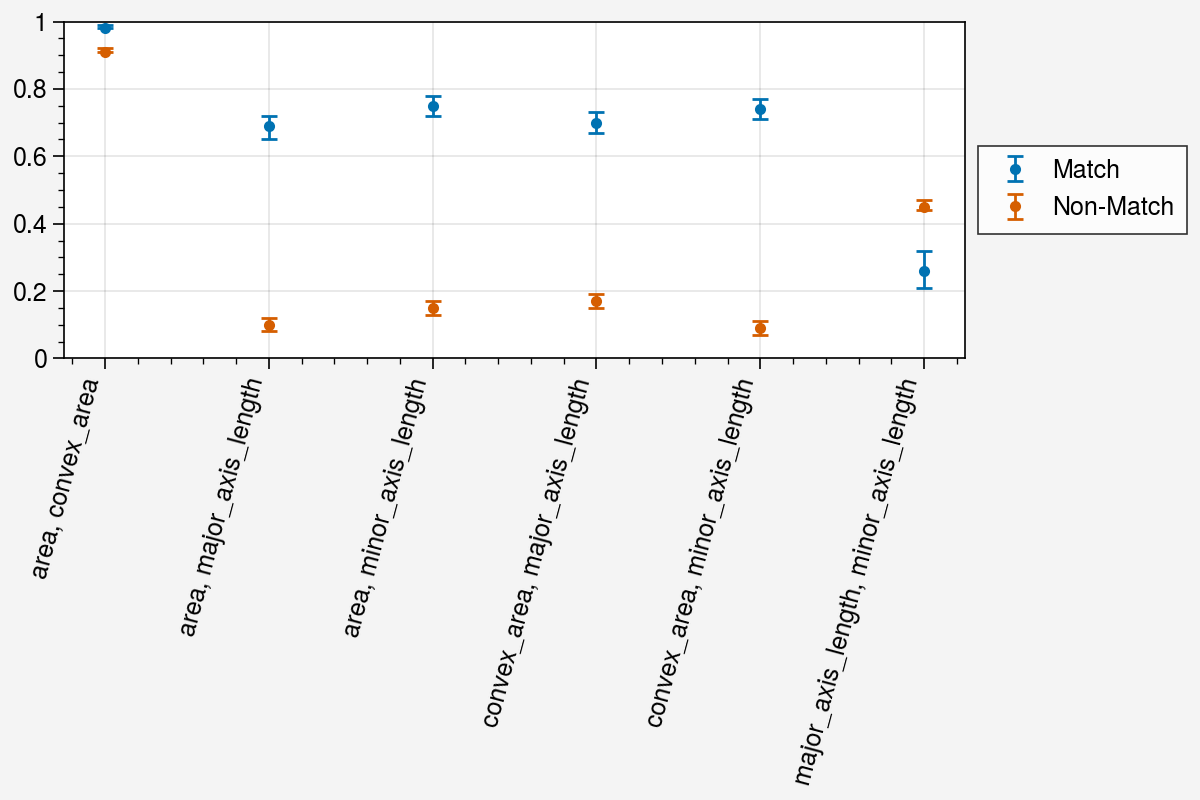

In [52]:
fig, ax = pplt.subplots(width=6, height=4 )
r = results.loc[results.match == 'tp', 'r'].values
cl = results.loc[results.match == 'tp', 'cl'].values
ch = results.loc[results.match == 'tp', 'ch'].values
ax.errorbar(x=np.arange(len(r)),
            y=results.loc[results.match == 'tp', 'r'].values,
            yerr=[r - cl,
                  ch - r], lw=0, elinewidth=1, marker='.',  label='Match')

r = results.loc[results.match == 'fp', 'r'].values
cl = results.loc[results.match == 'fp', 'cl'].values
ch = results.loc[results.match == 'fp', 'ch'].values
ax.errorbar(x=np.arange(len(r)),
            y=results.loc[results.match == 'fp', 'r'].values,
            yerr=[r - cl,
                  ch - r], lw=0, elinewidth=1, marker='.', label='Non-Match')

ax.format(xlocator=np.arange(len(r)), xformatter=[v1.replace('adr_', '') + ', ' + v2.replace('adr_', '') for v1, v2 in zip(
    results.loc[results.match == 'fp', 'var1'],
    results.loc[results.match == 'fp', 'var2'])], xrotation=75, ylim=(0, 1))
ax.legend(ncols=1, loc='r')

In [53]:
import scipy.stats as stats
data = df_all.loc[~df_all.true_match, :]
for var1 in ['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length']:
    for var2 in ['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length']:
        if var1 != var2:
            r = stats.pearsonr(data[var1], data[var2])
            print(np.round(r.statistic, 2), np.round(r.confidence_interval(), 2), var1, var2)

0.91 [0.91 0.92] adr_area adr_convex_area
0.1 [0.08 0.12] adr_area adr_major_axis_length
0.15 [0.13 0.17] adr_area adr_minor_axis_length
0.91 [0.91 0.92] adr_convex_area adr_area
0.17 [0.15 0.19] adr_convex_area adr_major_axis_length
0.09 [0.07 0.11] adr_convex_area adr_minor_axis_length
0.1 [0.08 0.12] adr_major_axis_length adr_area
0.17 [0.15 0.19] adr_major_axis_length adr_convex_area
0.45 [0.44 0.47] adr_major_axis_length adr_minor_axis_length
0.15 [0.13 0.17] adr_minor_axis_length adr_area
0.09 [0.07 0.11] adr_minor_axis_length adr_convex_area
0.45 [0.44 0.47] adr_minor_axis_length adr_major_axis_length


In [54]:
df_all.loc[df_all.true_match, ].corr()

,area,adr_area,adr_convex_area,adr_major_axis_length,adr_minor_axis_length,true_match
area,1.000000,-0.183326,-0.172899,-0.161070,-0.162583,NaN
adr_area,-0.183326,1.000000,0.983296,0.687596,0.749385,NaN
adr_convex_area,-0.172899,0.983296,1.000000,0.699750,0.738298,NaN
adr_major_axis_length,-0.161070,0.687596,0.699750,1.000000,0.264205,NaN
adr_minor_axis_length,-0.162583,0.749385,0.738298,0.264205,1.000000,NaN
true_match,NaN,NaN,NaN,NaN,NaN,NaN


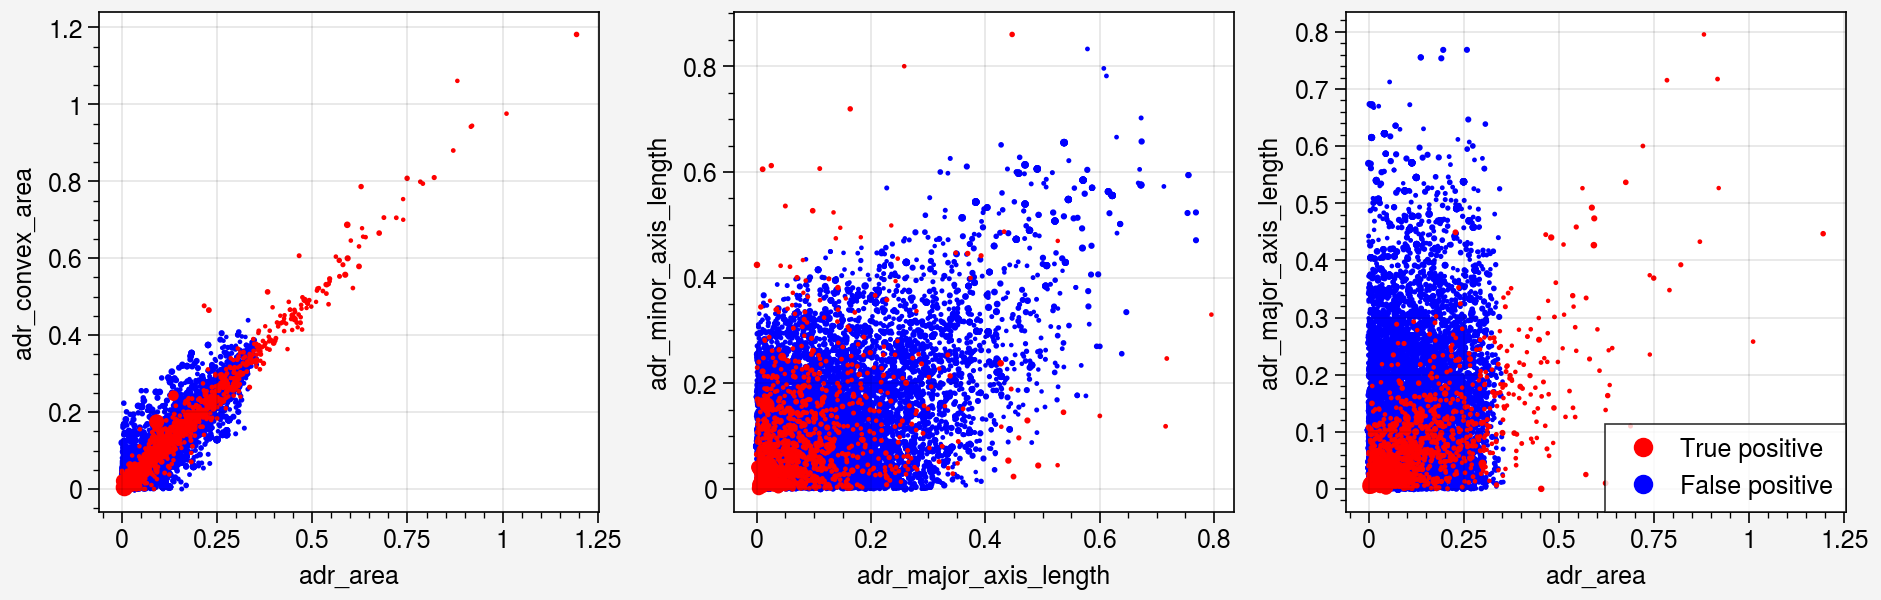

In [55]:
fig, ax = pplt.subplots(ncols=3, share=False)
ax[0].scatter(df_all['adr_area'], df_all['adr_convex_area'], c=df_all['true_match'].astype(int), cmap='bwr', s=df_all['area'])
ax[1].scatter(df_all['adr_major_axis_length'], df_all['adr_minor_axis_length'], c=df_all['true_match'].astype(int), cmap='bwr', s=df_all['area'])
ax[2].scatter(df_all['adr_area'], df_all['adr_major_axis_length'], c=df_all['true_match'].astype(int), cmap='bwr',  s=df_all['area'])
h = [ax[0].plot([],[],m='o', lw=0, color='r'),
      ax[0].plot([],[],m='o', lw=0, color='b')]
ax[2].legend(h, ['True positive', 'False positive'], ncols=1)

# Potential use of joint distribution thresholds
The ADR values for each measure are not independent. The strong mutual correlation (higher than 0.8 across the board in one experiment) tell us that while individual thresholds are not particularly powerful for filtering, combinations of measures may be useful. In the scatterplot above, I've taken the random matches (blue) and the true matches (red) and plotted joint distributions of each. Relative size of the floes is shown by the size of the dots. We can see that the true values tend to be fairly tightly clustered compared to the random values. Thus, we may have better success by looking at either

a. Joint probability distributions in multiple dimensions can be used to assign probabilities
b. Combination measures, such as the ADR of solidity and eccentricity, may have better explanatory power

I also note that the randomization within area bins limits the adr of the area: I should sample a range of sizes instead of within bins.